In [1]:
library("dplyr")
library(readr)
library('ggplot2')
library('matrixStats')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘matrixStats’

The following object is masked from ‘package:dplyr’:

    count



In [25]:
#install.packages("matrixStats")

options(repr.matrix.max.cols=1000, repr.matrix.max.rows=1000)

In [62]:
test <- read_csv("SurveyData.csv")
print(nrow(test))
print(ncol(test))
head(test)

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


[1] 14748
[1] 27


upbringing_poor,upbringing_upper,age_40,age_70,criminal_history_NonViolent,criminal_history_Violent,children_Two,occ_artist,occ_banker,occ_doctor,occ_firefighter,occ_janitor,occ_nurse,occ_scientist,occ_unemployed,health_Diabetic,health_MentalHealthIssues,health_PhysicallyDisabled,race_Asian,race_Black,race_Hispanic,pol_Democrat,pol_Republican,context,severity,Resp_Party,Answer
1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0
0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1,1
1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0
0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,1


In [64]:
test2cov <- na.omit(test)
MMRdata_subset<-test2cov

names(MMRdata_subset)[27] <- "Saved"
head(MMRdata_subset,2)


upbringing_poor,upbringing_upper,age_40,age_70,criminal_history_NonViolent,criminal_history_Violent,children_Two,occ_artist,occ_banker,occ_doctor,occ_firefighter,occ_janitor,occ_nurse,occ_scientist,occ_unemployed,health_Diabetic,health_MentalHealthIssues,health_PhysicallyDisabled,race_Asian,race_Black,race_Hispanic,pol_Democrat,pol_Republican,context,severity,Resp_Party,Saved
1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0


In [65]:
##### Initial ####
dataset.rows <- nrow(MMRdata_subset) 
n <- 3
set.seed(44)

no.of.attr <- 23
no.of.cov <- 3

startindex.cov <- no.of.attr+1
total.no.var <- no.of.attr+no.of.cov

levels.of.attr <- 2


rand_init <- as.data.frame(matrix(runif(dataset.rows*n, min=0.1,max=0.9), ncol = n))

In [66]:
# CONDITIONAL CLASS PROB
den <- rowSums(rand_init)
for(i in 1:n){
  rand_init[i] <- rand_init[i]/ den
  MMRdata_subset[, ncol(MMRdata_subset)+1] <- rand_init[i]
  colnames(MMRdata_subset)[ncol(MMRdata_subset)] <- paste0("classcond_prb",i)
}




head(MMRdata_subset,2)

upbringing_poor,upbringing_upper,age_40,age_70,criminal_history_NonViolent,criminal_history_Violent,children_Two,occ_artist,occ_banker,occ_doctor,occ_firefighter,occ_janitor,occ_nurse,occ_scientist,occ_unemployed,health_Diabetic,health_MentalHealthIssues,health_PhysicallyDisabled,race_Asian,race_Black,race_Hispanic,pol_Democrat,pol_Republican,context,severity,Resp_Party,Saved,classcond_prb1,classcond_prb2,classcond_prb3
1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0.4656994,0.2318837,0.3024169
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0.5144471,0.2479330,0.2376200


In [67]:
# Cluster Initialization for faster convergence

w1 <-runif(round(0.8* length(which(MMRdata_subset$context == 1 & MMRdata_subset$severity == 1))), min = 0.7, max = 0.95)
w2 <-runif(round(0.8* length(which(MMRdata_subset$context == 0 & MMRdata_subset$severity == 1))), min = 0.7, max = 0.95)
w3 <-runif(round(0.8* length(which(MMRdata_subset$context == 1 & MMRdata_subset$severity == 0))), min = 0.7, max = 0.95)
w4 <-runif(round(0.8* length(which(MMRdata_subset$context == 1 & MMRdata_subset$severity == 1))), min = 0.7, max = 0.95)

In [68]:

MMRdata_subset[sample(which(MMRdata_subset$context == 1 & MMRdata_subset$severity == 1),
              round(0.8* length(which(MMRdata_subset$context == 1 & MMRdata_subset$severity == 1)))), 
              "classcond_prb1"] <- w1
MMRdata_subset[sample(which(MMRdata_subset$context == 0 & MMRdata_subset$severity == 1),
              round(0.8* length(which(MMRdata_subset$context == 0 & MMRdata_subset$severity == 1)))), 
              "classcond_prb2"] <- w2
MMRdata_subset[sample(which(MMRdata_subset$context == 1 & MMRdata_subset$severity == 0),
              round(0.8* length(which(MMRdata_subset$context == 1 & MMRdata_subset$severity == 0)))), 
              "classcond_prb2"] <- w3
MMRdata_subset[sample(which(MMRdata_subset$context == 1 & MMRdata_subset$severity == 1),
              round(0.8* length(which(MMRdata_subset$context == 1 & MMRdata_subset$severity == 1)))), 
              "classcond_prb3"] <- w4


In [70]:
clsden<- rowSums(MMRdata_subset[(total.no.var+2) : (total.no.var+1+n)])
MMRdata_subset$classcond_prb1 <- MMRdata_subset$classcond_prb1/clsden
MMRdata_subset$classcond_prb2 <- MMRdata_subset$classcond_prb2/clsden
MMRdata_subset$classcond_prb3 <- MMRdata_subset$classcond_prb3/clsden


In [71]:
# Check if sum of assigned class conditional probablities sum up to 1
check <- rowSums(MMRdata_subset[(total.no.var+2) : (total.no.var+1+n)])
print(range(check))

[1] 1 1


In [72]:
# Add columns to record Unconditional Probability
for(i in 1:n){
  init<- rep(1, dataset.rows)
  MMRdata_subset[, ncol(MMRdata_subset)+1] <- init
  colnames(MMRdata_subset)[ncol(MMRdata_subset)] <- paste0("uncond_prb",i)
}


head(MMRdata_subset,2)

upbringing_poor,upbringing_upper,age_40,age_70,criminal_history_NonViolent,criminal_history_Violent,children_Two,occ_artist,occ_banker,occ_doctor,occ_firefighter,occ_janitor,occ_nurse,occ_scientist,occ_unemployed,health_Diabetic,health_MentalHealthIssues,health_PhysicallyDisabled,race_Asian,race_Black,race_Hispanic,pol_Democrat,pol_Republican,context,severity,Resp_Party,Saved,classcond_prb1,classcond_prb2,classcond_prb3,uncond_prb1,uncond_prb2,uncond_prb3
1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0.3045506,0.4976797,0.1977697,1,1,1
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0.5144471,0.2479330,0.2376200,1,1,1


In [73]:
# Display column names
colnames(MMRdata_subset[1:(no.of.attr)])

[1] "upbringing_poor"             "upbringing_upper"           
 [3] "age_40"                      "age_70"                     
 [5] "criminal_history_NonViolent" "criminal_history_Violent"   
 [7] "children_Two"                "occ_artist"                 
 [9] "occ_banker"                  "occ_doctor"                 
[11] "occ_firefighter"             "occ_janitor"                
[13] "occ_nurse"                   "occ_scientist"              
[15] "occ_unemployed"              "health_Diabetic"            
[17] "health_MentalHealthIssues"   "health_PhysicallyDisabled"  
[19] "race_Asian"                  "race_Black"                 
[21] "race_Hispanic"               "pol_Democrat"               
[23] "pol_Republican"

In [74]:
# Columns considered for regression
attrs<- colnames(MMRdata_subset[1:(no.of.attr)])
LR.formula <- formula(paste("Saved ~ ", paste(attrs, collapse = "+")))

params <- as.data.frame(matrix(nrow = no.of.attr+1, ncol = n))
Vni<- as.data.frame(matrix(nrow=dataset.rows ,ncol = n))
Pni<- as.data.frame(matrix(nrow=dataset.rows ,ncol = n))

num <- as.data.frame(matrix(nrow=dataset.rows ,ncol = n))
clsprob<-as.data.frame(matrix(nrow=dataset.rows ,ncol = n))

iter<- 0
loglike <- 0

# Add columns to record Choice Probability
for(i in 1:n){
  MMRdata_subset[, ncol(MMRdata_subset)+1] <- rep(0,dataset.rows)
  colnames(MMRdata_subset)[ncol(MMRdata_subset)] <- paste0("choice_prb",i)
}

In [76]:
# Verify newly added columns and order
colnames(MMRdata_subset)

[1] "upbringing_poor"             "upbringing_upper"           
 [3] "age_40"                      "age_70"                     
 [5] "criminal_history_NonViolent" "criminal_history_Violent"   
 [7] "children_Two"                "occ_artist"                 
 [9] "occ_banker"                  "occ_doctor"                 
[11] "occ_firefighter"             "occ_janitor"                
[13] "occ_nurse"                   "occ_scientist"              
[15] "occ_unemployed"              "health_Diabetic"            
[17] "health_MentalHealthIssues"   "health_PhysicallyDisabled"  
[19] "race_Asian"                  "race_Black"                 
[21] "race_Hispanic"               "pol_Democrat"               
[23] "pol_Republican"              "context"                    
[25] "severity"                    "Resp_Party"                 
[27] "Saved"                       "classcond_prb1"             
[29] "classcond_prb2"              "classcond_prb3"             
[31] "uncond_prb1"                 "uncond_prb2"                
[33] "uncond_prb3"                 "choice_prb1"                
[35] "choice_prb2"                 "choice_prb3"

In [77]:
# Function for the Maximazation Step of EM Algorithm 
M_step <- function(MMRdata_subset, LR.formula)
{
  attrs<- colnames(MMRdata_subset[1:(no.of.attr)])
  LR.formula <- formula(paste("Saved ~ ", paste(attrs, collapse = "+")))
    
  for(i in 1:n) {
    #print(i)
    #print(LR.formula)
    model <- glm(formula = LR.formula, weights = MMRdata_subset[[total.no.var+1+n+i]], data=MMRdata_subset, family= "binomial")
    params[i] <- summary(model)$coefficients[,1]
    
      
      
    Vni[i] <- params[1,i] + params[2,i]* MMRdata_subset[[1]] + params[3,i]* MMRdata_subset[[2]] +
              params[4,i]* MMRdata_subset[[3]] + params[5,i]* MMRdata_subset[[4]] + params[6,i]* MMRdata_subset[[5]] +
              params[7,i]* MMRdata_subset[[6]] + params[8,i]* MMRdata_subset[[7]] + params[9,i]* MMRdata_subset[[8]] +
              params[10,i]* MMRdata_subset[[9]] + params[11,i]* MMRdata_subset[[10]] + params[12,i]* MMRdata_subset[[11]] +
              params[13,i]* MMRdata_subset[[12]] + params[14,i]* MMRdata_subset[[13]] + params[15,i]* MMRdata_subset[[14]] +
              params[16,i]* MMRdata_subset[[15]] + params[17,i]* MMRdata_subset[[16]] + params[18,i]* MMRdata_subset[[17]] +
              params[19,i]* MMRdata_subset[[18]] + params[20,i]* MMRdata_subset[[19]] + params[21,i]* MMRdata_subset[[20]] +
              params[22,i]* MMRdata_subset[[21]] + params[23,i]* MMRdata_subset[[22]] + params[24,i]* MMRdata_subset[[23]]
    
    if(i==1) {model1 <- model}
    if(i==2) {model2 <- model}
    if(i==3) {model3 <- model}
  }
  
  q <- Vni %>% 
        mutate(a1 = apply(X = Vni, MARGIN = 1, FUN = function(x) exp(x - logSumExp(x))[1]),
               a2 = apply(X = Vni, MARGIN = 1, FUN = function(x) exp(x - logSumExp(x))[2]),
               a3 = apply(X = Vni, MARGIN = 1, FUN = function(x) exp(x - logSumExp(x))[3]),
               a4 = apply(X = Vni, MARGIN = 1, FUN = function(x) exp(x - logSumExp(x))[4]))
                      
    
  for (i in 1:n) {
      Pni[i] <- q[n+i]^MMRdata_subset[[total.no.var+1]]
    }
  
  
  list("params" = params, 
       "Ch_prb" = Pni,
        "model1" = model1,
        "model2" = model2,
        "model3" = model3)
}

In [78]:
# Function for the Expectation Step of EM Algorithm
E_step <- function(MMRdata_subset)
{
  # Conditional Class Probability - eq 8
  for (i in 1:n) {
    num[i] <- MMRdata_subset[total.no.var+1+2*n+i] * MMRdata_subset[total.no.var+1+n+i]
  }
  
  den <- rowSums(num) 
  
  for (i in 1:n){
    clsprob[i] <- num[i]/den
  }
  
  list("clsprob" = clsprob)
}

In [ ]:
sum_ll<-0
iter<-0
LogLike_iter <- vector()

# Iterations of the EM algorithm until convergence 
while(iter< 3000)
{
  
  iter<- iter+1
  #print(iter)
  
  # E step function call
  if (iter > 1 )
  {
    start_time <- Sys.time()
    e.out <- E_step(MMRdata_subset)
    
    
    #Update clsprob to dataset dataframe
    MMRdata_subset[(total.no.var+1+1) : (total.no.var+1+n)]<- e.out$clsprob
    
    end_time <- Sys.time()
    
  }
  
  
  
  
  # Unconditional Class Probability - eq 6
  
  # Mean of similar covariate combinations
  x<- MMRdata_subset%>%
    group_by(context,severity,Resp_Party) %>% 
    summarise_at(vars(matches("classcond_prb")),mean)
    
  
  # create concatenation of attribute combinations
  x$comb <- apply(x[1:no.of.cov],1,paste,collapse="")
  MMRdata_subset$comb <- apply(MMRdata_subset[startindex.cov:(startindex.cov+no.of.cov-1)],1,paste,collapse="")
  
  # assigning respective mean values 
  for (q in x[[no.of.cov+n+1]]) {
    for (j in 1:n) {
      MMRdata_subset[which(MMRdata_subset$comb == q), total.no.var+1+n+j] <- x[which(x$comb == q), no.of.cov+j]
    }
  }
  
  
  # M STEP func call 
  
  start_time <- Sys.time()
  m.out <- M_step(MMRdata_subset, LR.formula)
  end_time <- Sys.time()
  #print("mstep:")
  #print((end_time-start_time))
  
  #param1.hist[,iter]<-m.out$params[1]
  #param2.hist[,iter]<-m.out$params[2]
  #param3.hist[,iter]<-m.out$params[3]
  
    
  #ClassCond1.hist[,iter]<-MMRdata_subset$classcond_prb1
  #ClassCond2.hist[,iter]<-MMRdata_subset$classcond_prb2
  #ClassCond3.hist[,iter]<-MMRdata_subset$classcond_prb3
    
  #Initialize : update choice probabilities on dataset dataframe
  start_time <- Sys.time()
  MMRdata_subset[(total.no.var+1+2*n+1):(total.no.var+1+2*n+n)] <- m.out$Ch_prb
  prev_loglike <- sum_ll
  
  # LOG LIKELIHOOD
  LL <- as.data.frame(matrix(data = rep(0, dataset.rows), nrow=dataset.rows ,ncol = 1))
  LogL <- as.data.frame(matrix(data = rep(0, dataset.rows), nrow=dataset.rows ,ncol = 1))
  
  for (i in 1:n) {
    # choice_prb * uncon_prb
    LL <- LL + (MMRdata_subset[no.of.attr+1+2*n+i] * MMRdata_subset[no.of.attr+1+n+i])
    
  }
  

  LogL<- log(LL)
  sum_ll <- sum(LogL)
  loglike<-rbind(loglike, sum_ll)
  
  if (iter%%500 == 0) {
    filename<-paste(paste('C3_2_init1_itersave_', iter,sep = ''), 'csv', sep='.')
    write.csv(MMRdata_subset,filename, row.names=FALSE)
      
    filename1<-paste(paste('C3_2_init1_itersave_params', iter,sep = ''), 'csv', sep='.')
    write.csv(m.out$params,filename1, row.names=FALSE)
  }
  print(paste(iter,sum_ll))
  LogLike_iter <- append(LogLike_iter, sum_ll)
  end_time <- Sys.time()
  #print("Loglike:")
  #print((end_time-start_time))
  
}


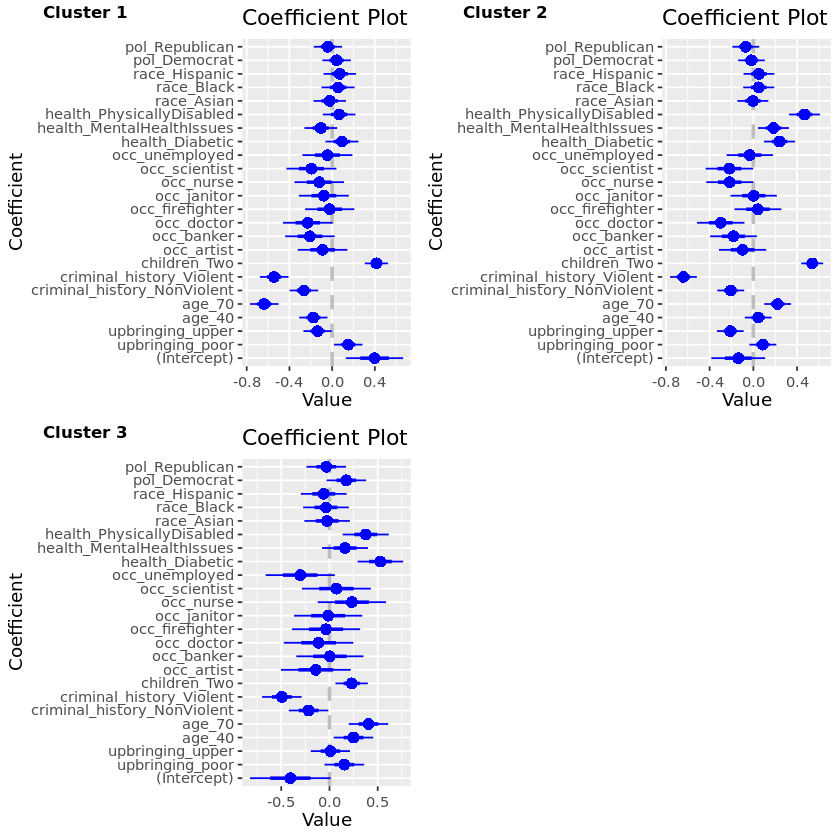

In [90]:
m1<-coefplot(m.out$model1)
m2<-coefplot(m.out$model2)
m3<-coefplot(m.out$model3)
plot_grid(m1, m2, m3, labels = c('Cluster 1', 'Cluster 2','Cluster 3'),label_size = 10)

In [85]:
install.packages("cowplot")
library("cowplot" )

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


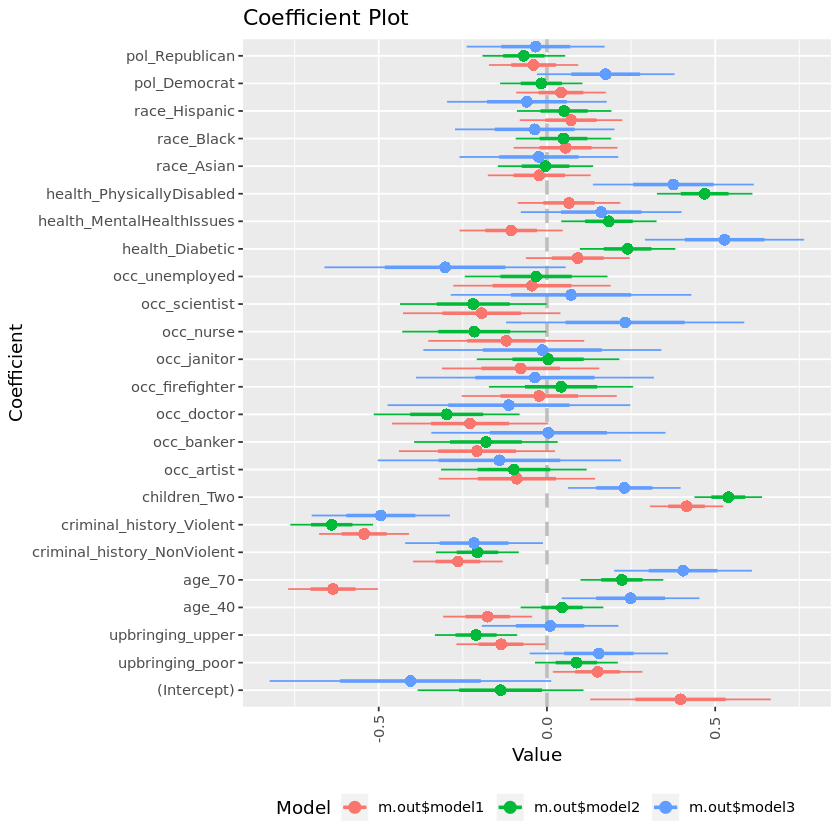

In [78]:
library("cowplot" )
library("coefplot")
multiplot(m.out$model1,m.out$model2,m.out$model3)

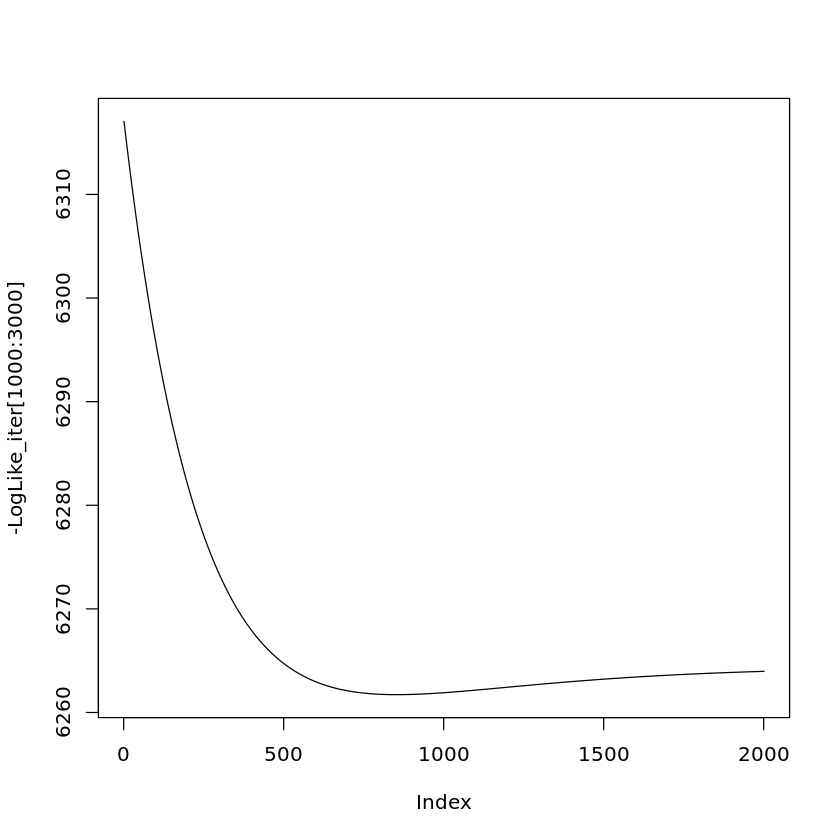

In [92]:
plot(-LogLike_iter[1000:3000], type='l')

In [2]:
iterload <- read_csv("itersave_1000.csv")
head(iterload)
library(ggplot2)

MMRdata_subset = iterload

Parsed with column specification:
cols(
  Intervention = col_double(),
  Fitness = col_double(),
  Gender = col_double(),
  SocialStatus = col_double(),
  Age = col_double(),
  Species = col_double(),
  Utilitarian = col_double(),
  Country = col_double(),
  Saved = col_double(),
  classcond_prb1 = col_double(),
  classcond_prb2 = col_double(),
  classcond_prb3 = col_double(),
  uncond_prb1 = col_double(),
  uncond_prb2 = col_double(),
  uncond_prb3 = col_double(),
  choice_prb1 = col_double(),
  choice_prb2 = col_double(),
  choice_prb3 = col_double(),
  comb = col_double()
)


Intervention,Fitness,Gender,SocialStatus,Age,Species,Utilitarian,Country,Saved,classcond_prb1,classcond_prb2,classcond_prb3,uncond_prb1,uncond_prb2,uncond_prb3,choice_prb1,choice_prb2,choice_prb3,comb
0,0,1,0,0,0,0,4,1,5.506759e-08,8.372874e-13,0.9999999,4.88376e-08,7.375163e-13,1,0.3427102,0.3450538,0.3122360,4
0,0,0,0,0,0,0,4,0,5.017443e-08,7.576539e-13,0.9999999,4.88376e-08,7.375163e-13,1,1.0000000,1.0000000,1.0000000,4
0,0,0,0,1,0,0,4,0,5.017443e-08,7.576539e-13,0.9999999,4.88376e-08,7.375163e-13,1,1.0000000,1.0000000,1.0000000,4
0,0,0,0,0,0,0,4,0,5.017443e-08,7.576539e-13,0.9999999,4.88376e-08,7.375163e-13,1,1.0000000,1.0000000,1.0000000,4
0,1,0,0,0,0,0,4,0,5.017443e-08,7.576539e-13,0.9999999,4.88376e-08,7.375163e-13,1,1.0000000,1.0000000,1.0000000,4
0,0,0,0,0,0,1,4,1,4.766598e-08,7.234270e-13,1.0000000,4.88376e-08,7.375163e-13,1,0.3270535,0.3286976,0.3442489,4


### Information Criteria

In [93]:
# k - number of parameters
k = 24 * n
aic = -2*sum_ll + 2*k
bic = -2*sum_ll + k*log(dataset.rows)
aicc = -2*sum_ll + 2*k*(dataset.rows / (dataset.rows - k - 1))
caic = -2*sum_ll + k*(log(dataset.rows) + 1)

In [87]:
model2000_1 = m.out$model1
model2000_2 = m.out$model2
model2000_3 = m.out$model3

In [94]:
print(paste("Log Likelihood = ", sum_ll))
print(paste("AIC = ", aic))
print(paste("BIC = ", bic))
print(paste("AICC = ", aicc))
print(paste("CAIC = ", caic))


[1] "Log Likelihood =  -6263.9689295669"
[1] "AIC =  12671.9378591338"
[1] "BIC =  13219.0559778073"
[1] "AICC =  12672.6541794064"
[1] "CAIC =  13291.0559778073"


In [89]:
IC <- c(iter, sum_ll, aic, bic, aicc, caic)
IC
capture.output(IC, file = "C3_2_init1_iter2000.txt")  

[1]  2000.000 -6261.908 12667.815 13214.934 12668.532 13286.934

In [142]:
ci.1 <- confint(model2000_1)
ci.2 <- confint(model2000_2)
ci.3 <- confint(model2000_3)
CI<- as.data.frame(matrix(nrow = no.of.attr+1, ncol = 2*n))
#CI <- CI$model1
#colnames(CI)
#names(CI)[1] <- "model1_2.5%"
#names(CI)[2] <- "model1_97.5%"

In [153]:
#CI<-CI[7:12]
CI
filename<-paste(paste('ConfidenceIntervals',sep = ''), 'csv', sep='.')
write.csv(CI,filename, row.names=FALSE)


CI<- as.data.frame(matrix(nrow = no.of.attr+1, ncol = 2*n))
CI['model3_2.5%']<-ci.3[,1]
CI['model3_97.5']<-ci.3[,2]

model1_2.5%,model1_97.5,model2_2.5%,model2_97.5,model3_2.5%,model3_97.5
0.09168527,0.64395050,-0.61478088,-0.102402148,-0.170322975,0.49138548
0.03943803,0.31288551,-0.04105048,0.213930544,-0.059826600,0.26927207
-0.41916554,-0.14495959,-0.24310363,0.008887364,-0.152536512,0.17386721
-0.33387082,-0.05933348,0.04843072,0.302266037,-0.200363327,0.12554067
-0.50337496,-0.22736976,0.31382966,0.568093200,-0.710714850,-0.38365439
-0.37511782,-0.10018080,-0.32679965,-0.072682194,-0.426347930,-0.09795059
-0.81043067,-0.53446653,-0.70779481,-0.453685702,-0.602873161,-0.27423300
0.25930124,0.48382800,0.35459994,0.562169886,0.380629119,0.64894773
-0.35936966,0.11814131,-0.32874417,0.120045044,-0.341065024,0.23394359
-0.58337937,-0.10481586,-0.29423334,0.142865185,-0.333976432,0.23517314


In [159]:
#Cluster exploration
class1 = MMRdata_subset[which((MMRdata_subset$classcond_prb1 > MMRdata_subset$classcond_prb2) &
                     (MMRdata_subset$classcond_prb1 > MMRdata_subset$classcond_prb3)), ]

class2 = MMRdata_subset[which((MMRdata_subset$classcond_prb2 > MMRdata_subset$classcond_prb1) &
                     (MMRdata_subset$classcond_prb2 > MMRdata_subset$classcond_prb3)), ]

class3 = MMRdata_subset[which((MMRdata_subset$classcond_prb3 > MMRdata_subset$classcond_prb1) &
                     (MMRdata_subset$classcond_prb3 > MMRdata_subset$classcond_prb2)), ]

In [160]:
# Cluster 1 contents
nrow(class1)
distinct(class1[24:26])

[1] 3856

context,severity,Resp_Party
1,1,1
0,0,0
0,1,0
0,0,1
0,1,1
0,0,2
0,1,2


In [161]:
# Cluster 3 contents
nrow(class3)
distinct(class3[24:26])

[1] 3041

context,severity,Resp_Party
1,1,1
1,1,0
0,0,1
1,1,2


In [162]:
# Cluster 1 demographic breakdown
class1 %>% group_by(context, severity, Resp_Party) %>% tally()

context,severity,Resp_Party,n
0,0,0,2220
0,0,1,857
0,0,2,260
0,1,0,236
0,1,1,56
0,1,2,3
1,1,1,224


In [163]:
# Cluster 2 demographic breakdown
class2 %>% group_by(context, severity, Resp_Party) %>% tally()

context,severity,Resp_Party,n
0,1,0,2164
0,1,1,1064
0,1,2,417
1,0,0,2140
1,0,1,1388
1,0,2,320
1,1,2,358


In [16]:
# Cluster 3 demographic breakdown
class3 %>% group_by(context, severity, Resp_Party) %>% tally()

context,severity,Resp_Party,n
1,0,0,205
1,0,1,1388
1,1,2,422


In [64]:
# The unconditional class probabilities of each type of person
x

context,severity,Resp_Party,classcond_prb1,classcond_prb2,classcond_prb3,classcond_prb4,comb
0,0,0,9.026662e-01,0.09716888,1.186634e-05,1.531028e-04,000
0,0,1,3.884359e-01,0.15106119,2.037066e-03,4.584659e-01,001
0,0,2,8.619905e-01,0.04203297,8.180104e-02,1.417550e-02,002
0,1,0,1.910361e-01,0.78195160,9.374488e-06,2.700297e-02,010
0,1,1,1.528489e-01,0.79711181,4.269979e-05,4.999657e-02,011
0,1,2,9.871753e-02,0.90116723,1.151457e-04,8.972554e-08,012
1,0,0,4.388350e-02,0.59545212,3.422809e-01,1.838348e-02,100
1,0,1,5.093111e-02,0.12151850,6.643359e-01,1.632145e-01,101
1,0,2,1.962285e-11,0.80813759,3.119577e-04,1.915505e-01,102
1,1,0,1.900096e-02,0.02600073,9.807113e-05,9.549002e-01,110
